# Cyberbullying Detection Model Training

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import os
import pickle
from time import time

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

plt.style.use("ggplot")
sns.set_style('darkgrid')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
DATASET_PATH = "data/dataset.csv"
MODELS_DIR = "models/"
TEST_SIZE = 0.2
RANDOM_STATE = 42

os.makedirs(MODELS_DIR, exist_ok=True)

In [16]:
def load_data(path):
    try:
        df = pd.read_csv(path)
        print(f"Dataset loaded successfully. Shape: {df.shape}")
        df['Text'] = df['Text'].astype(str)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
        return None

df = load_data(DATASET_PATH)
if df is not None:
    display(df.head())

Dataset loaded successfully. Shape: (11100, 2)


,Text,CB_Label
0,damn there is someones nana up here at beach w...,0
1,no kidding! dick clark was a corpse mechanical...,0
2,i read an article on jobros and thought damn w...,0
3,I got one fucking day of sprinkles and now it'...,0
4,I was already listening to Elliott smith and ...,0


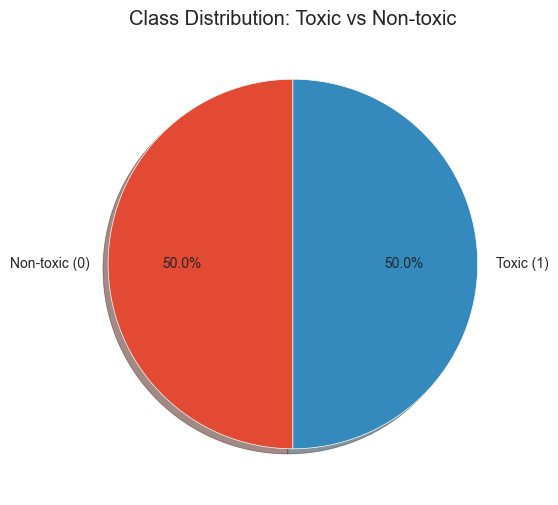

In [17]:
def plot_distribution(df, target_col='CB_Label'):
    if target_col not in df.columns:
        print(f"Column '{target_col}' not found.")
        return
        
    counts = df[target_col].value_counts()
    labels = ["Non-toxic (0)", "Toxic (1)"]
    
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
    plt.title("Class Distribution: Toxic vs Non-toxic")
    plt.show()

if df is not None:
    plot_distribution(df)

In [18]:
def advanced_clean_text(text):
    if not isinstance(text, str):
        return []

    # Lowercase
    text = text.lower()
    
    # Remove Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

def preprocess_corpus(df, text_col='Text'):
    print("Starting advanced preprocessing...")
    
    # Apply basic cleaning and tokenization
    df['tokens'] = df[text_col].apply(advanced_clean_text)
    
    # Initialize Stemmer and Lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    # Apply Stemming
    df['stemmed'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
    
    # Apply Lemmatization
    df['lemmatized'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # Join tokens back to string for TF-IDF
    df['final_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))
    
    print("Preprocessing complete.")
    return df

if df is not None:
    df = preprocess_corpus(df)
    print("Cleaned & Tokenized Sample:")
    display(df[['Text', 'tokens', 'stemmed', 'lemmatized']].head())

Starting advanced preprocessing...
Preprocessing complete.
Cleaned & Tokenized Sample:


,Text,tokens,stemmed,lemmatized
0,damn there is someones nana up here at beach w...,"[damn, someones, nana, beach, one, dont, think...","[damn, someon, nana, beach, one, dont, think, ...","[damn, someone, nana, beach, one, dont, think,..."
1,no kidding! dick clark was a corpse mechanical...,"[kidding, dick, clark, corpse, mechanically, o...","[kid, dick, clark, corps, mechan, oper, advert...","[kidding, dick, clark, corpse, mechanically, o..."
2,i read an article on jobros and thought damn w...,"[read, article, jobros, thought, damn, cash, j...","[read, articl, jobro, thought, damn, cash, job...","[read, article, jobros, thought, damn, cash, j..."
3,I got one fucking day of sprinkles and now it'...,"[got, one, fucking, day, sprinkles, back, suns...","[got, one, fuck, day, sprinkl, back, sunshin, ...","[got, one, fucking, day, sprinkle, back, sunsh..."
4,I was already listening to Elliott smith and ...,"[already, listening, elliott, smith, fucking, ...","[alreadi, listen, elliott, smith, fuck, hate, ...","[already, listening, elliott, smith, fucking, ..."


In [19]:
def extract_features(df, text_col='final_text', label_col='CB_Label'):
    X = df[text_col]
    y = df[label_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    print(f"Training Set shape: {X_train.shape}")
    print(f"Test Set shape: {X_test.shape}")

    tfidf_vectorizer = TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 3),
        max_features=10000
    )
    
    print("Fitting TF-IDF with N-grams... this may take a moment.")
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    # Save the vectorizer
    vec_filename = os.path.join(MODELS_DIR, 'tfidf_vectorizer.pkl')
    with open(vec_filename, 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    print(f"Vectorizer saved to {vec_filename}")
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

if df is not None:
    X_train_vec, X_test_vec, y_train, y_test = extract_features(df)

Training Set shape: (8880,)
Test Set shape: (2220,)
Fitting TF-IDF with N-grams... this may take a moment.
Vectorizer saved to models/tfidf_vectorizer.pkl


In [20]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier

In [21]:
def train_evaluate_models(X_train, y_train, X_test, y_test):
    models = [
        LinearSVC(),
        LogisticRegression(max_iter=1000),
        MultinomialNB(),
        DecisionTreeClassifier(),
        AdaBoostClassifier(),
        BaggingClassifier(),
        SGDClassifier(),
        RandomForestClassifier(n_estimators=100),
    ]
    
    results_list = []
    
    print(f"{'Algorithm':<25} {'Accuracy':<10} {'F1-Score':<10} {'Time(s)':<10}")
    print("-"*60)
    
    for model in models:
        model_name = model.__class__.__name__
        
        start_time = time()
        model.fit(X_train, y_train)
        train_time = time() - start_time
        
        with open(os.path.join(MODELS_DIR, f"{model_name}.pkl"), 'wb') as f:
            pickle.dump(model, f)
            
        pred_test = model.predict(X_test)
        pred_train = model.predict(X_train)
        
        metrics = {
            'Algorithm': model_name,
            'Accuracy Test': accuracy_score(y_test, pred_test),
            'Accuracy Train': accuracy_score(y_train, pred_train),
            'F1 Test': f1_score(y_test, pred_test, average='weighted'),
            'Precision Test': precision_score(y_test, pred_test, average='weighted', zero_division=0),
            'Recall Test': recall_score(y_test, pred_test, average='weighted', zero_division=0),
            'Training Time': train_time
        }
        
        results_list.append(metrics)
        print(f"{model_name:<25} {metrics['Accuracy Test']:.4f}     {metrics['F1 Test']:.4f}     {train_time:.4f}")
        
    return pd.DataFrame(results_list)

if df is not None:
    results_df = train_evaluate_models(X_train_vec, y_train, X_test_vec, y_test)
    display(results_df.sort_values(by='F1 Test', ascending=False))

Algorithm                 Accuracy   F1-Score   Time(s)   
------------------------------------------------------------
LinearSVC                 0.6991     0.6988     0.0324
LogisticRegression        0.7293     0.7287     0.1310
MultinomialNB             0.7027     0.7025     0.0026
DecisionTreeClassifier    0.6680     0.6680     1.8505
AdaBoostClassifier        0.5743     0.5406     0.6662
BaggingClassifier         0.7090     0.7078     10.1985
SGDClassifier             0.7068     0.7055     0.0264
RandomForestClassifier    0.7248     0.7217     10.2946


,Algorithm,Accuracy Test,Accuracy Train,F1 Test,Precision Test,Recall Test,Training Time
1,LogisticRegression,0.729279,0.846622,0.728690,0.730353,0.729279,0.130988
7,RandomForestClassifier,0.724775,0.990991,0.721722,0.732692,0.724775,10.294648
5,BaggingClassifier,0.709009,0.966104,0.707763,0.711284,0.709009,10.198487
6,SGDClassifier,0.706757,0.883559,0.705518,0.708957,0.706757,0.026389
2,MultinomialNB,0.702703,0.853266,0.702490,0.702831,0.702703,0.002576
0,LinearSVC,0.699099,0.950225,0.698819,0.699308,0.699099,0.032359
3,DecisionTreeClassifier,0.668018,0.990991,0.668010,0.668005,0.668018,1.850509
4,AdaBoostClassifier,0.574324,0.575225,0.540605,0.612806,0.574324,0.666247


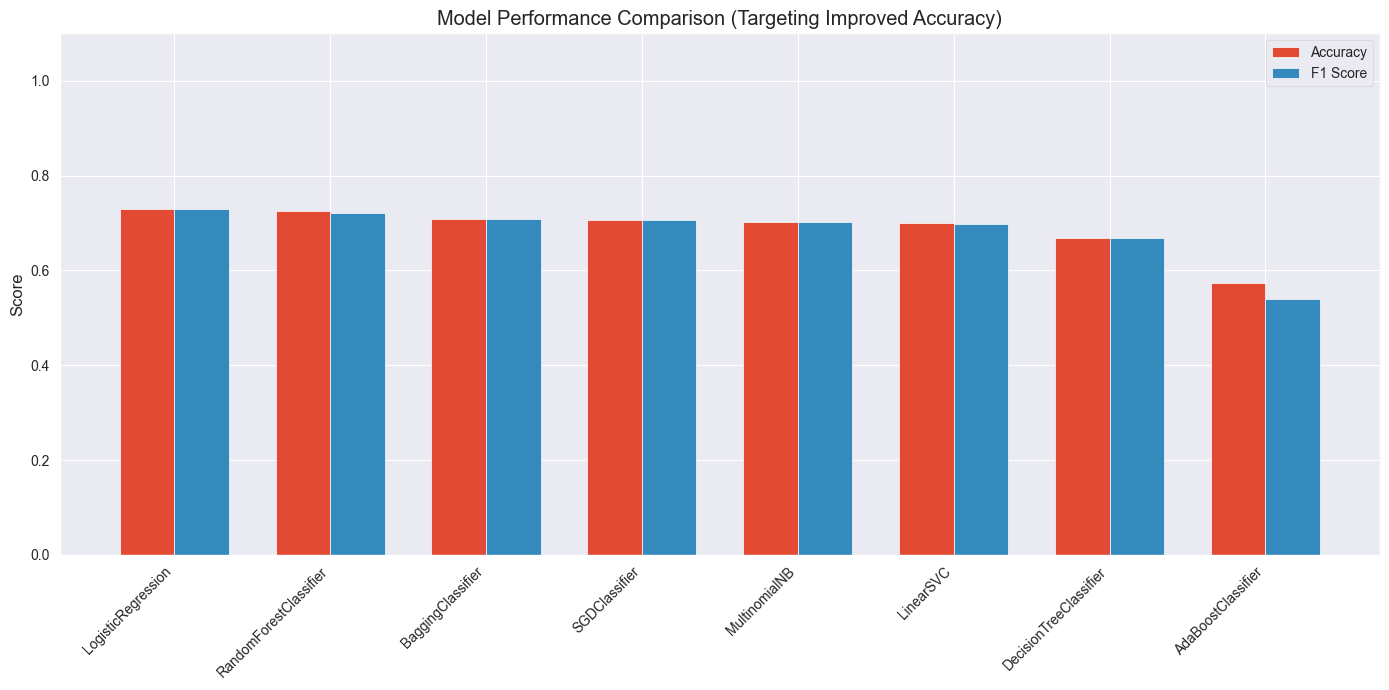

In [22]:
if df is not None and not results_df.empty:
    plt.figure(figsize=(14, 7))
    
    # Sort by F1 Score
    results_sorted = results_df.sort_values(by='F1 Test', ascending=False)
    
    # Bar Plot
    x = np.arange(len(results_sorted))
    width = 0.35
    
    plt.bar(x - width/2, results_sorted['Accuracy Test'], width, label='Accuracy')
    plt.bar(x + width/2, results_sorted['F1 Test'], width, label='F1 Score')
    
    plt.ylabel('Score')
    plt.title('Model Performance Comparison (Targeting Improved Accuracy)')
    plt.xticks(x, results_sorted['Algorithm'], rotation=45, ha='right')
    plt.legend()
    plt.ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()

In [23]:
if df is not None and not results_df.empty:
    # Identify best model by F1 Test score
    best_model_row = results_df.loc[results_df['F1 Test'].idxmax()]
    best_model_name = best_model_row['Algorithm']
    best_f1_score = best_model_row['F1 Test']
    
    print(f"Best Performing Model: {best_model_name} with F1-Score: {best_f1_score:.4f}")
    
    best_model_path = os.path.join(MODELS_DIR, f"{best_model_name}.pkl")
    
    print(f"Best model is already saved at: {best_model_path}")

Best Performing Model: LogisticRegression with F1-Score: 0.7287
Best model is already saved at: models/LogisticRegression.pkl
